In [14]:
from tensorflow.python.keras.layers import Input, Dense, Dropout, LSTM, Activation
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

In [ ]:
#rom tensorflow.keras.models import Sequential
#rom tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
#rom tensorflow.keras import layers


In [16]:
SPX = pd.read_fwf('data/SPX.txt' ,names=['Date', 'Close'], parse_dates=True)

In [17]:
SPX.head()

,Date,Close
0,06/01/1995,"460,68"
1,13/01/1995,"465,97"
2,20/01/1995,"464,78"
3,27/01/1995,"470,39"
4,03/02/1995,"478,64"


In [18]:
#SPX.Date = pd.to_datetime(SPX.Date, infer_datetime_format=True)

In [20]:
VIX = pd.read_fwf('data/VIX.txt' ,names=['Date', 'Close'], parse_dates=True)

In [21]:
VIX.head()

,Date,Close
0,06/01/1995,"13,13"
1,13/01/1995,"11,1"
2,20/01/1995,"12,15"
3,27/01/1995,"11,25"
4,03/02/1995,"10,98"


In [22]:
SPX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1292 non-null   object
 1   Close   1292 non-null   object
dtypes: object(2)
memory usage: 20.3+ KB


In [23]:
SPX.describe()

,Date,Close
count,1292,1292
unique,1292,1243
top,07/06/2002,"1122,7"
freq,1,3


In [24]:
SPX['Close'] = SPX['Close'].apply(lambda x: float(x.split()[0].replace(',', '.')))
VIX['Close'] = VIX['Close'].apply(lambda x: float(x.split()[0].replace(',', '.')))

In [ ]:
# SPX = SPX.set_index('Date')
# VIX = VIX.set_index('Date')

In [25]:
#SPX.index = pd.to_datetime(SPX.index,unit='ns')
#VIX.index = pd.to_datetime(VIX.index,unit='ns')
print(SPX.index)
print(VIX.index)

RangeIndex(start=0, stop=1292, step=1)
RangeIndex(start=0, stop=1292, step=1)


In [26]:
SPX.head()

,Date,Close
0,06/01/1995,460.68
1,13/01/1995,465.97
2,20/01/1995,464.78
3,27/01/1995,470.39
4,03/02/1995,478.64


In [27]:
SPX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1292 non-null   object 
 1   Close   1292 non-null   float64
dtypes: float64(1), object(1)
memory usage: 20.3+ KB


## **EVOLUTION DES NOS DONNEES**

In [28]:
def Plotting_evolution(data):
    data['Close'].plot(figsize=(18, 6))
    plt.show()

EVOLUTION DE SPX_Data DANS LE TEMPS


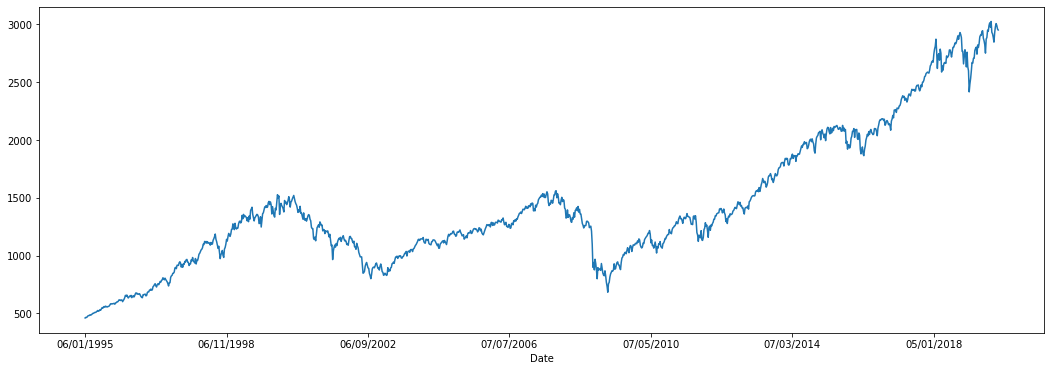

EVOLUTION DE VIX_Data DANS LE TEMPS


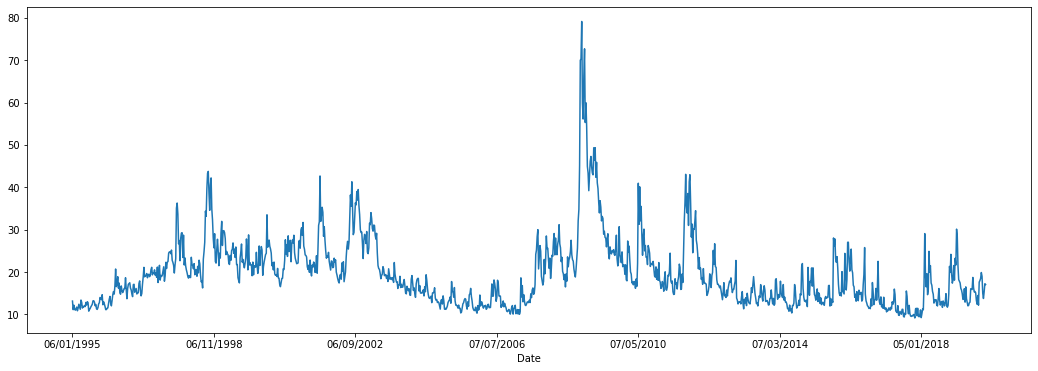

In [29]:
SPX_ = SPX.set_index('Date')
VIX_ = VIX.set_index('Date')
data = [SPX_, VIX_]
Names =  ['SPX_Data', 'VIX_Data']

for i in range(len(data)):
    print('EVOLUTION DE {} DANS LE TEMPS'.format(Names[i]))
    Plotting_evolution(data[i])

In [30]:
SPX_data = SPX.copy()
SPX_data['Date'] = pd.to_datetime(SPX_data['Date'])
SPX_data = SPX_data.set_index('Date')
SPX_data.head()

,Close
Date,
1995-06-01,460.68
1995-01-13,465.97
1995-01-20,464.78
1995-01-27,470.39
1995-03-02,478.64


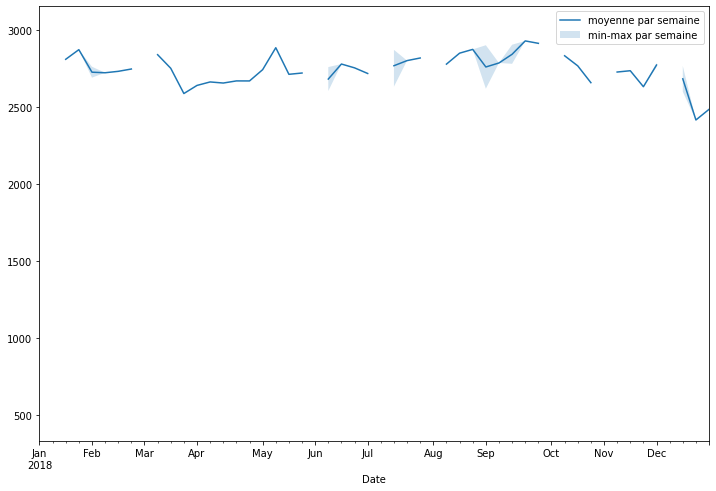

In [31]:
m = SPX_data['Close'].resample('W').agg(['mean', 'std', 'min', 'max'])

plt.figure(figsize=(12, 8))
m['mean']['2018'].plot(label='moyenne par semaine')
plt.fill_between(m.index, m['max'], m['min'], alpha=0.2, label='min-max par semaine')

plt.legend()
plt.show()

array([<AxesSubplot:xlabel='Date'>], dtype=object)

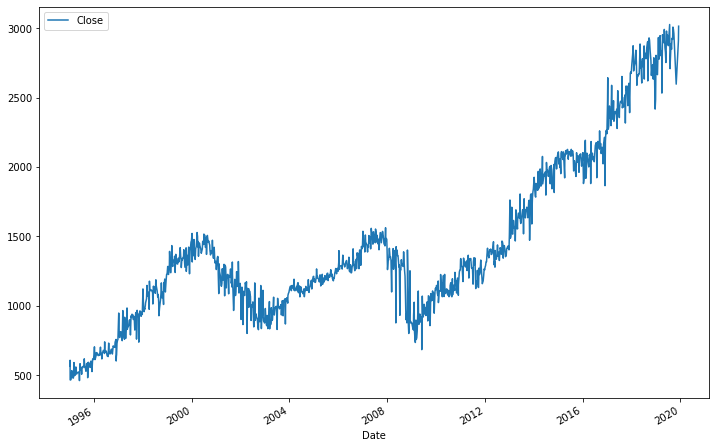

In [32]:
SPX_data[['Close']].plot(subplots=True, figsize=(12, 8))

In [ ]:
#df = SPX.copy()
#df.groupby('Date').resample('D').mean()

## SPLIT DATA

In [33]:
train_SPX = SPX.loc[0:1110,'Close']
test_SPX = SPX.loc[1110:,'Close']

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(14, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('SPX/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

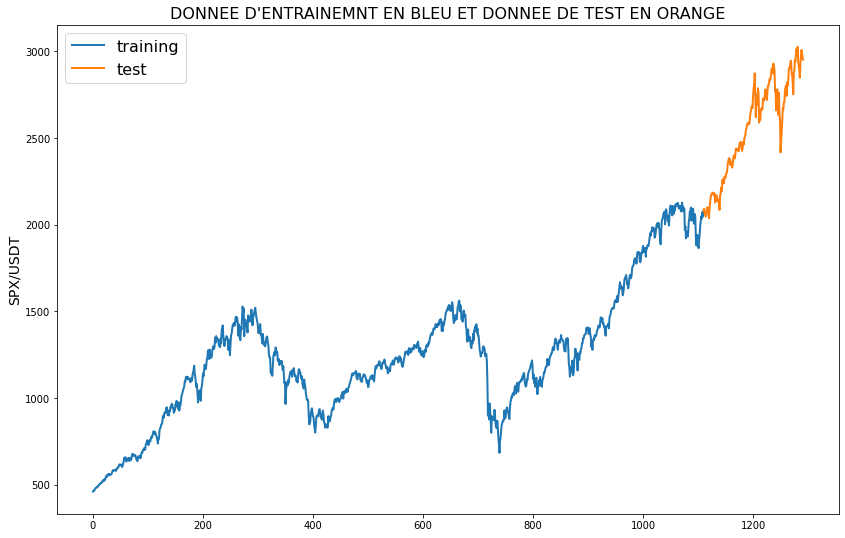

In [35]:
line_plot(train_SPX, test_SPX, 'training', 'test', title="DONNEE D'ENTRAINEMNT EN BLEU ET DONNEE DE TEST EN ORANGE")

---

## ON VEUT PREDIRE LE COURS DES 7 PROCHAIN JOURS

## TRAINING DATA

<AxesSubplot:>

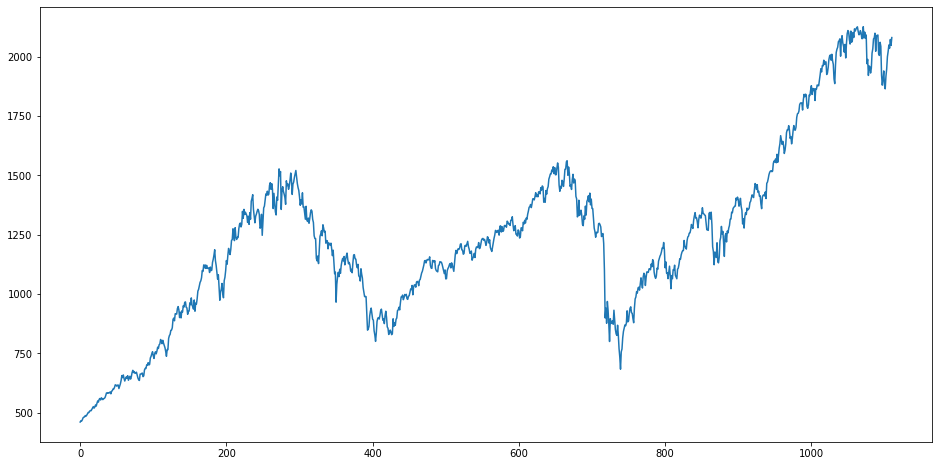

In [36]:
train_SPX.plot(figsize=(16,8))

## TEST DATA

<AxesSubplot:>

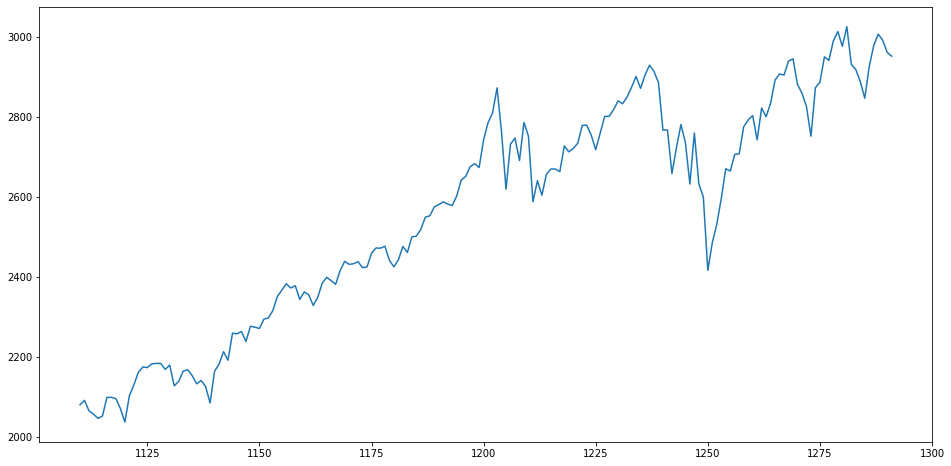

In [37]:
test_SPX.plot(figsize=(16,8))

# NORMALISATION DE DONNEES


In [38]:
def normalise_zero_base(data):
    return data / data.iloc[0] - 1

def normalise_min_max(data):
    return (data - data.min()) / (data.max() - data.min())

In [39]:
def extract_window_data(data, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(data) - window_len):
        tmp = data[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [40]:
def prepare_data(train_SPX, test_SPX,window_len=10, zero_base=True, test_size=0.2):
    X_train = extract_window_data(train_SPX, window_len, zero_base)
    X_test = extract_window_data(test_SPX, window_len, zero_base)
    y_train = train_SPX[window_len:].values
    y_test = test_SPX[window_len:].values
    if zero_base:
        y_train = y_train / train_SPX[:-window_len].values - 1
        y_test = y_test / test_SPX[:-window_len].values - 1
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return train_SPX, test_SPX, X_train, X_test, y_train, y_test

# MODELISATION 1 LSTM

- Creation de modele lstm

In [41]:
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

- Les paramettres pour l'entrainement du model

In [42]:
np.random.seed(245)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.24
optimizer = 'adam'

## PREPARATION DES DONNES

In [46]:
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
train_SPX, test_SPX, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [47]:
print('Len of X training data', X_train.shape)
print('Len of Y training data',y_train.shape)
print('------------------------------')
print('Len of X test data',X_test.shape)
print('Len of y test data',y_test.shape)

Len of X training data (1106, 5, 1)
Len of Y training data (1106,)
------------------------------
Len of X test data (177, 5, 1)
Len of y test data (177,)


## TRAINING MODELE 1 LSTM

In [48]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
     

Epoch 1/40
35/35 [==============================] - 4s 22ms/step - loss: 0.0017 - val_loss: 5.8993e-04
Epoch 2/40
35/35 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 5.3731e-04
Epoch 3/40
35/35 [==============================] - 0s 8ms/step - loss: 9.6783e-04 - val_loss: 4.4620e-04
Epoch 4/40
35/35 [==============================] - 0s 8ms/step - loss: 9.1673e-04 - val_loss: 4.1931e-04
Epoch 5/40
35/35 [==============================] - 0s 8ms/step - loss: 8.6774e-04 - val_loss: 3.9750e-04
Epoch 6/40
35/35 [==============================] - 0s 14ms/step - loss: 8.0661e-04 - val_loss: 3.7091e-04
Epoch 7/40
35/35 [==============================] - 0s 11ms/step - loss: 7.6056e-04 - val_loss: 3.5301e-04
Epoch 8/40
35/35 [==============================] - 0s 13ms/step - loss: 7.1965e-04 - val_loss: 3.3921e-04
Epoch 9/40
35/35 [==============================] - 0s 12ms/step - loss: 6.7446e-04 - val_loss: 3.3336e-04
Epoch 10/40
35/35 [==============================

## COURBE D'ENTRAINEMENT ET DE TEST

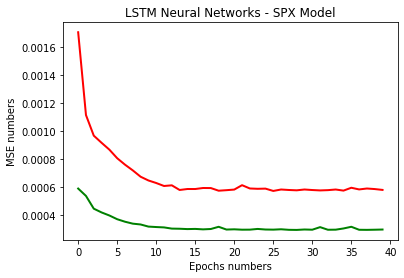

In [49]:
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - SPX Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [50]:
targets = test_SPX[window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.012241533014473506

In [51]:
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

0.00029724357893148195

In [52]:
from sklearn.metrics import r2_score
r2_score1=r2_score(y_test, preds)
r2_score1*100

74.23091927653327

In [53]:
preds = test_SPX.values[:-window_len] * (preds + 1)
preds

array([2055.22951893, 2061.28203502, 2103.7805356 , 2109.21628919,
       2103.23240254, 2078.62737819, 2047.85884935, 2104.80404345,
       2139.84490204, 2168.97217112, 2179.53016696, 2180.51189188,
       2188.32708808, 2191.9031098 , 2192.23876297, 2178.19641104,
       2186.88425674, 2141.52560663, 2145.63495147, 2171.46696818,
       2179.94053884, 2162.32275224, 2141.04718451, 2148.1939186 ,
       2137.62459931, 2097.75651099, 2164.1492461 , 2192.90203325,
       2220.66052551, 2198.73692194, 2260.00804605, 2267.72298281,
       2271.91469048, 2246.01416173, 2281.51425254, 2284.96294808,
       2281.06322035, 2299.15594716, 2306.98368152, 2323.24574239,
       2356.3378826 , 2375.69050567, 2389.82311485, 2380.94471916,
       2385.34767416, 2355.57498193, 2369.7129373 , 2366.26348456,
       2341.90247574, 2354.17854745, 2391.78434002, 2409.44990093,
       2399.63312809, 2389.14457057, 2421.09927261, 2448.09603033,
       2442.41349118, 2439.78110304, 2446.123177  , 2434.74746

In [54]:
#preds.plot(figsize=(16,8))

In [55]:
preds = pd.Series(index=targets.index, data=preds)
preds

1115    2055.229519
1116    2061.282035
1117    2103.780536
1118    2109.216289
1119    2103.232403
           ...     
1287    2930.767237
1288    2990.535423
1289    3019.174678
1290    3000.755892
1291    2971.823939
Length: 177, dtype: float64

# PREDICTION DU MODEL 1 LSTM

<AxesSubplot:>

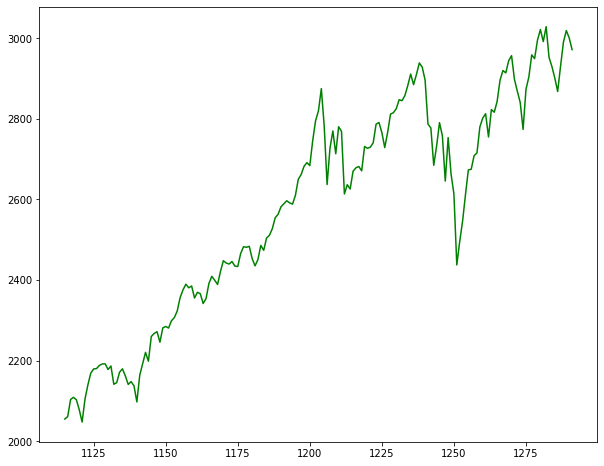

In [56]:
preds = pd.Series(index=targets.index, data=preds)
preds.plot(figsize=(10,8) , c='g')

## VRAIE DONNE DU TEST

<AxesSubplot:>

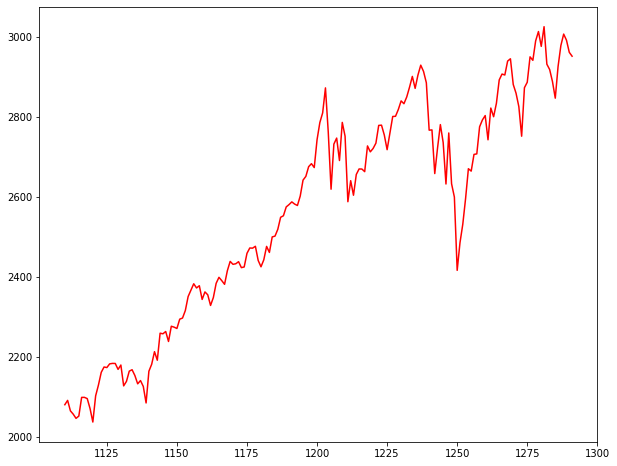

In [57]:
test_SPX.plot(figsize=(10,8), c='r')

## COMPARAISON DES VRAIE DONNEE AVEC LES PREDICTIONS

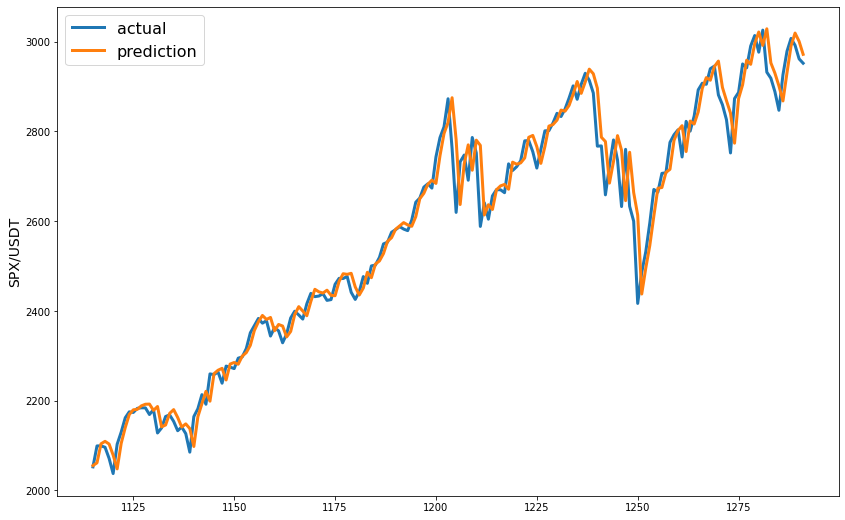

In [58]:
line_plot(targets, preds, 'actual', 'prediction', lw=3)

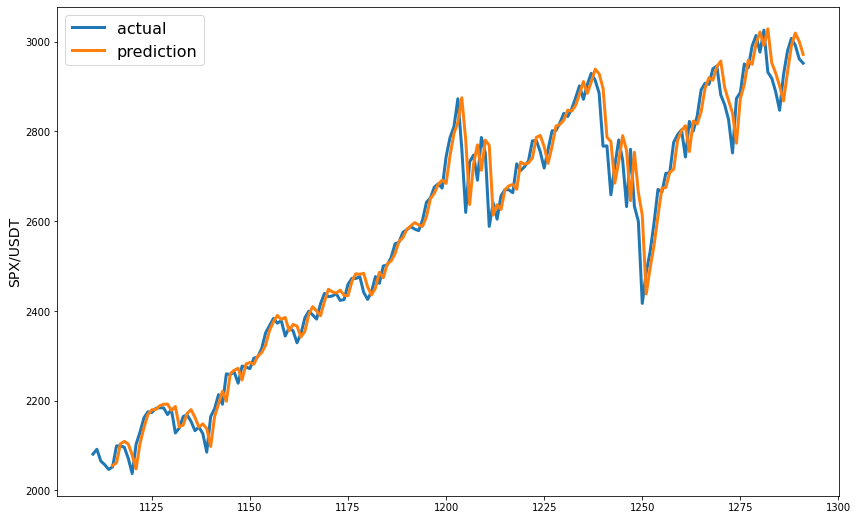

In [59]:
line_plot(test_SPX, preds, 'actual', 'prediction', lw=3)

## PREDICTION DU MODEL SUR LES DONNEES DE TEST

In [60]:
train_SPX = SPX.loc[0:1110,'Close']
test_SPX = preds

def line_plot(line1, line2,line3 ,label1=None, label2=None, label3=None,title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(14, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw, c='orange')
    #ax.plot(line2, label=label2, linewidth=lw, c='o')
    ax.plot(line3, label=label3, linewidth=lw, c='g')
    ax.set_ylabel('SPX/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

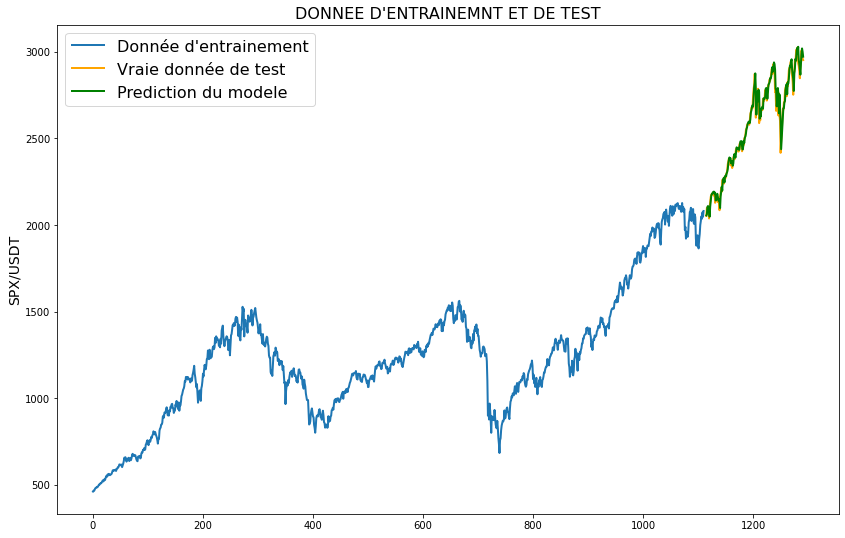

In [63]:
line_plot(train_SPX, targets,preds, "Donnée d'entrainement", "Vraie donnée de test", 'Prediction du modele', title="DONNEE D'ENTRAINEMNT ET DE TEST")

---

## MODEL 2 Recurrent Neural network AVEC KERAS

In [66]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, LSTM, Activation, GRU
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from pandas import Series
from tensorflow.python.keras import optimizers

In [67]:
df = SPX.set_index('Date')
data=df.copy()

In [68]:
data.head()

,Close
Date,
06/01/1995,460.68
13/01/1995,465.97
20/01/1995,464.78
27/01/1995,470.39
03/02/1995,478.64


In [69]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        #takes 
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [70]:
look_back=7
numpy.random.seed(0)

# load the dataset
dataframe = data
dataset = dataframe.values
dataset = dataset.astype('float64').reshape(-1, 1)
# normalize the dataset
scaler = MinMaxScaler()
#scaler=RobustScaler()
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
#look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network


## CREATE MODEL

In [71]:
model = Sequential()

model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
#model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
model.add(LSTM(256))
model.add(Dense(1))

## COMPILE MODEL

In [72]:
#keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1)

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, verbose=1,shuffle=False,batch_size=50)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
predictions = numpy.empty_like(dataset)
predictions[:, :] = numpy.nan
predictions[look_back:len(trainPredict)+look_back, :] = trainPredict
predictions[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
#data=pd.DataFrame(numpy.concatenate((trainPredict[0:len(trainPredict)-look_back-1],testPredict[0:len(testPredict)-look_back-1])),columns=["predicted"])
#print('one',data.count())
#print('two',dataframe.count())
predictionsDF=pd.DataFrame(predictions,columns=["predicted"],index=dataframe.index)
ans=pd.concat([dataframe,predictionsDF],axis=1)
print( ans,[look_back,trainScore,testScore])

Epoch 1/50
18/18 [==============================] - 13s 35ms/step - loss: 0.0290
Epoch 2/50
18/18 [==============================] - 1s 33ms/step - loss: 0.0084
Epoch 3/50
18/18 [==============================] - 1s 35ms/step - loss: 0.0031
Epoch 4/50
18/18 [==============================] - 1s 40ms/step - loss: 0.0023
Epoch 5/50
18/18 [==============================] - 1s 44ms/step - loss: 0.0012
Epoch 6/50
18/18 [==============================] - 1s 48ms/step - loss: 4.9928e-04
Epoch 7/50
18/18 [==============================] - 1s 43ms/step - loss: 3.1457e-04
Epoch 8/50
18/18 [==============================] - 1s 32ms/step - loss: 3.1048e-04
Epoch 9/50
18/18 [==============================] - 1s 30ms/step - loss: 3.0679e-04
Epoch 10/50
18/18 [==============================] - 1s 40ms/step - loss: 3.0052e-04
Epoch 11/50
18/18 [==============================] - 1s 34ms/step - loss: 2.9661e-04
Epoch 12/50
18/18 [==============================] - 1s 32ms/step - loss: 2.9402e-04
Epoch 13

# PREDICTION

In [84]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(14, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw, c='r')
    #ax.plot(line2, label=label2, linewidth=lw, c='o')
    #ax.plot(line3, label=label3, linewidth=lw, c='g')
    ax.set_ylabel('SPX/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

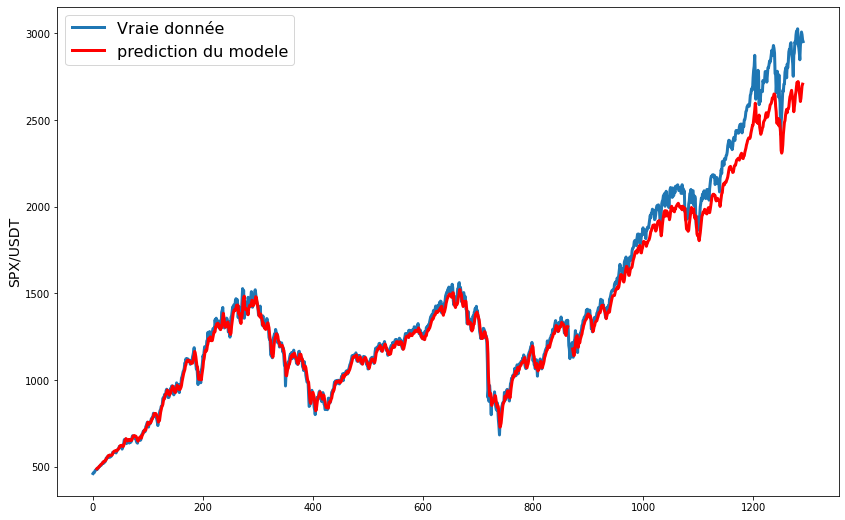

In [85]:
line_plot(SPX['Close'], predictions, 'Vraie donnée', 'prediction du modele', lw=3)

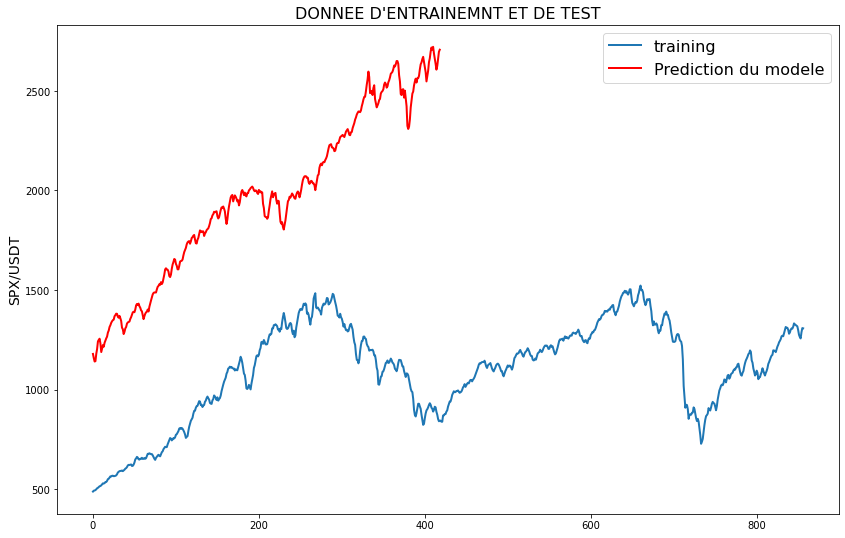

In [86]:
line_plot(trainPredict, testPredict, 'training', 'Prediction du modele', title="DONNEE D'ENTRAINEMNT ET DE TEST")

# MODEL 3 GRU

### PREPARE DATA

In [110]:
X = np.array(SPX['Close'])
X = X.reshape((1292, 1))

training_data_len = math.ceil(len(X)* 0.75)

sc = MinMaxScaler(feature_range=(0,1))
training_data = sc.fit_transform(X)
training_data

array([[0.        ],
       [0.00206228],
       [0.00159837],
       ...,
       [0.98682323],
       [0.97501092],
       [0.97122942]])

In [111]:
split_val = 887
train_data = training_data[0:split_val  , : ]

X_train = []
y_train = []
for i in range(180, len(train_data)):
    X_train.append(train_data[i-180:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('Nombre des lignes et colonnes: ', X_train.shape)

test_data = training_data[split_val - 180: , : ]
X_test = []
y_test =  X[split_val : , : ]
for i in range(180,len(test_data)):
    X_test.append(test_data[i-180:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Nombre des lignes et colonnes : ', X_test.shape)


Nombre des lignes et colonnes:  (707, 180, 1)
Nombre des lignes et colonnes :  (405, 180, 1)


### CREATE MODEL

In [112]:
model_GRU = Sequential()
model_GRU.add(LSTM(units = 200, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences = True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences = True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units = 50))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(units = 1))

### COMPILE MODELE

In [113]:
model_GRU.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error')


## FIT MODEL

In [ ]:
model_GRU.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
23/23 [==============================] - 104s 3s/step - loss: 0.0143
Epoch 2/30
23/23 [==============================] - 66s 3s/step - loss: 0.0037
Epoch 3/30
23/23 [==============================] - 68s 3s/step - loss: 0.0025
Epoch 4/30
23/23 [==============================] - 65s 3s/step - loss: 0.0025
Epoch 5/30
23/23 [==============================] - 69s 3s/step - loss: 0.0019
Epoch 6/30
23/23 [==============================] - 68s 3s/step - loss: 0.0019
Epoch 7/30
23/23 [==============================] - 84s 4s/step - loss: 0.0017
Epoch 8/30
23/23 [==============================] - 57s 2s/step - loss: 0.0014
Epoch 9/30
23/23 [==============================] - 46s 2s/step - loss: 0.0015
Epoch 10/30
23/23 [==============================] - 51s 2s/step - loss: 0.0016
Epoch 11/30
20/23 [=========================>....] - ETA: 7s - loss: 0.0015

In [ ]:
#sc = MinMaxScaler(feature_range=(0,1))

In [ ]:
pred = model_GRU.predict(X_test)
#pred = sc.inverse_transform(pred)
train = data[:split_val]
valid = data[split_val:]
valid['Predictions'] = pred
score = r2_score(y_test, pred)
score